<a href="https://colab.research.google.com/github/brianbene/explainableDL_10062025/blob/main/Explainable_DL_10062025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this assignment, I'll be working with the dataset class for GTRSB traffic design dataset. I aim to finetune the ResNet-50 Model for the selected dataset and then conduct analysis of my model via GradCAM and other variants such as Deconvnet and SmoothGrad.

In [2]:
#Let's begin by importing our modules. I've opted to employ pytorch.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download and load the training and validation datasets
image_datasets = {x: datasets.GTSRB(root='./data', split=x, download=True, transform=data_transforms[x])
                  for x in ['train', 'test']}

print("GTSRB dataset downloaded and loaded")

100%|██████████| 187M/187M [09:25<00:00, 332kB/s]
100%|██████████| 89.0M/89.0M [05:04<00:00, 293kB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 196kB/s]


GTSRB dataset downloaded and loaded


In [4]:
# Create data loaders for training and testing
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = list(range(43))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Data loaders created.")

Data loaders created.


In [5]:
#Let's load ResNet

model=models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(512, 43),)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


In [8]:
#Let's go ahead and train the model
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs=5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print("-"*10)
    for images, labels in dataloaders['train']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    print(f"Loss: {loss.item()}")

Epoch 1/5
----------
Loss: 1.8341081142425537
Epoch 2/5
----------
Loss: 1.0919644832611084
Epoch 3/5
----------
Loss: 0.5827271938323975
Epoch 4/5
----------
Loss: 1.598414421081543
Epoch 5/5
----------
Loss: 0.7808344960212708


In [9]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in dataloaders['test']:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 62.72%


As we see above, the loss is decreasing, indicating the model has learned. I lowered the learning rate from the previous iteration to remove some of the instability along with reducing the number of passthroughs; for the purposes of this assignment,we needn't train the model for too many epochs.An accuracy of 60% is not ideal. Let's explore further

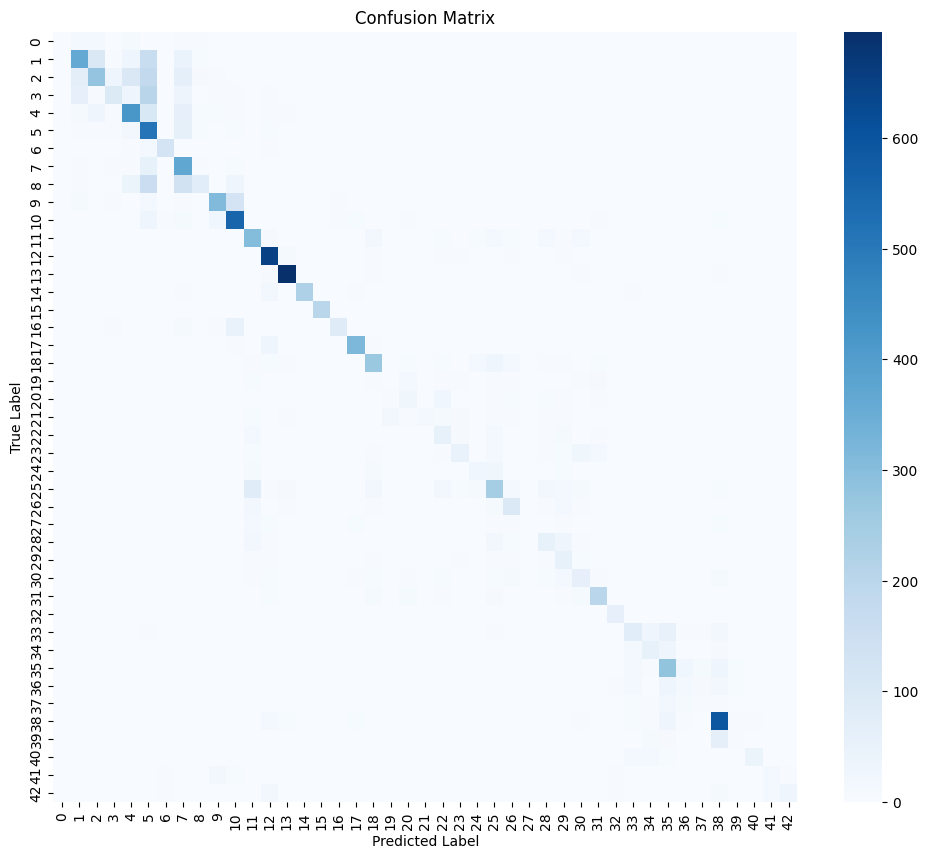

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.66      0.50      0.57       720
           2       0.63      0.37      0.47       750
           3       0.58      0.21      0.31       450
           4       0.63      0.63      0.63       660
           5       0.35      0.81      0.49       630
           6       0.90      0.83      0.87       150
           7       0.46      0.82      0.59       450
           8       0.66      0.17      0.27       450
           9       0.81      0.65      0.72       480
          10       0.69      0.84      0.76       660
          11       0.60      0.73      0.66       420
          12       0.78      0.94      0.86       690
          13       0.93      0.97      0.95       720
          14       0.99      0.83      0.91       270
          15       0.99      0.96      0.97       210
          16       0.88      0.55      0.67       150
          17       0.87    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for confusion matrix
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in dataloaders['test']:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(all_targets, all_preds))

The above confusion matrix above elucidates the fact that recall is not as high as we would perhaps like for detecting traffic signs that are rarer. For classes 12-15, we see the model performs well; common street signs have a greater amount of training data, therefore better recall. Let's explore the inner workings of our trained model with Grad CAM.

In [11]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=fed205c20d22ed7e1fccb9265a879c5f67562f41e2083b4addf457253d8fe7c8
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [12]:
# Unfreeze layer4 and the final classification layer
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True




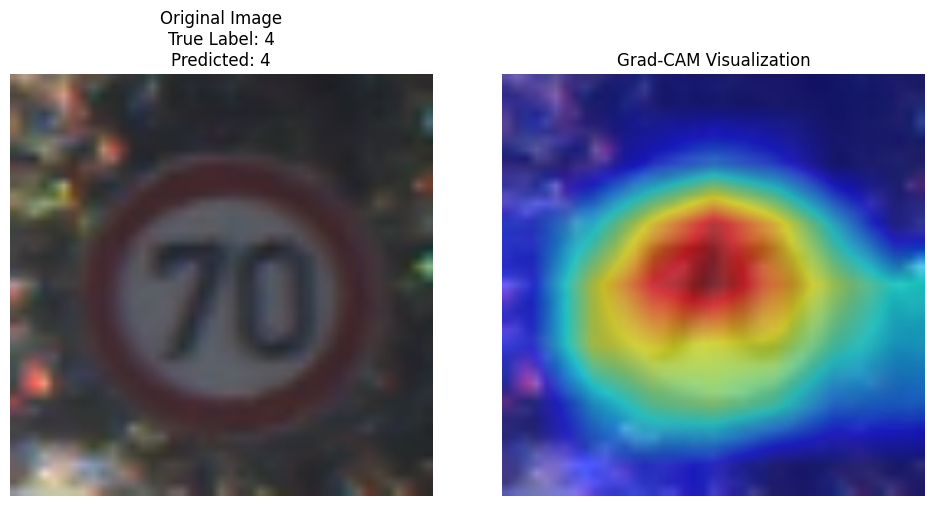

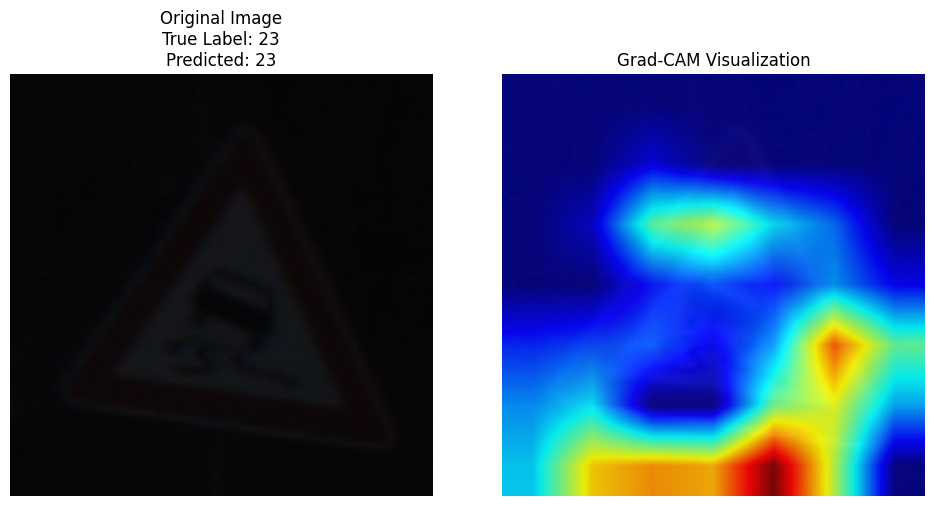

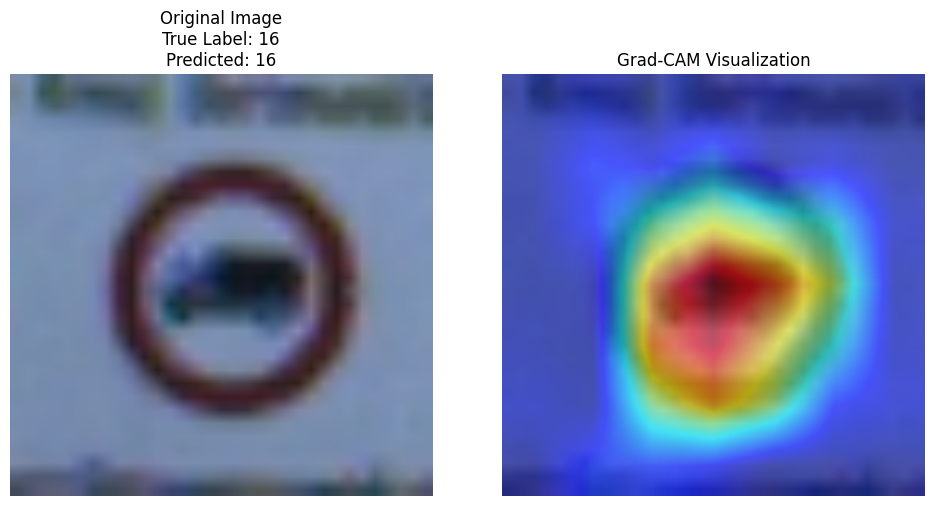

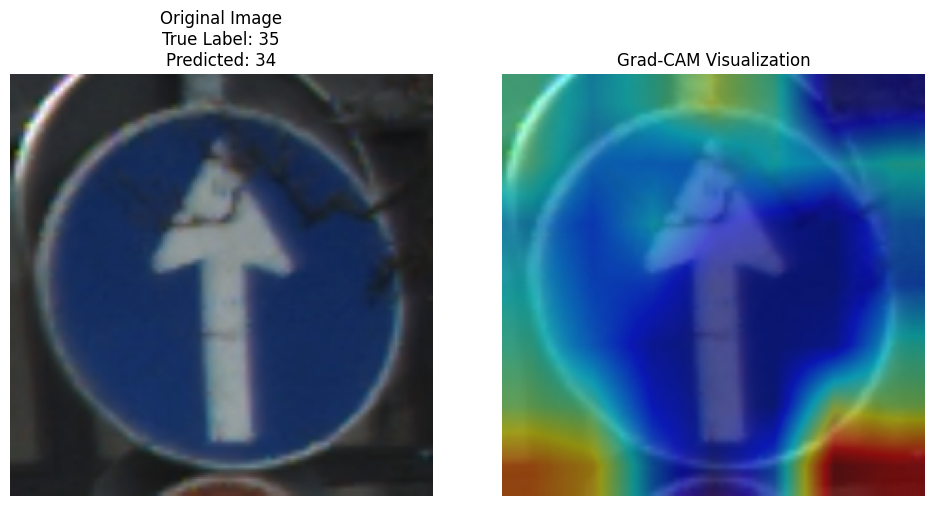

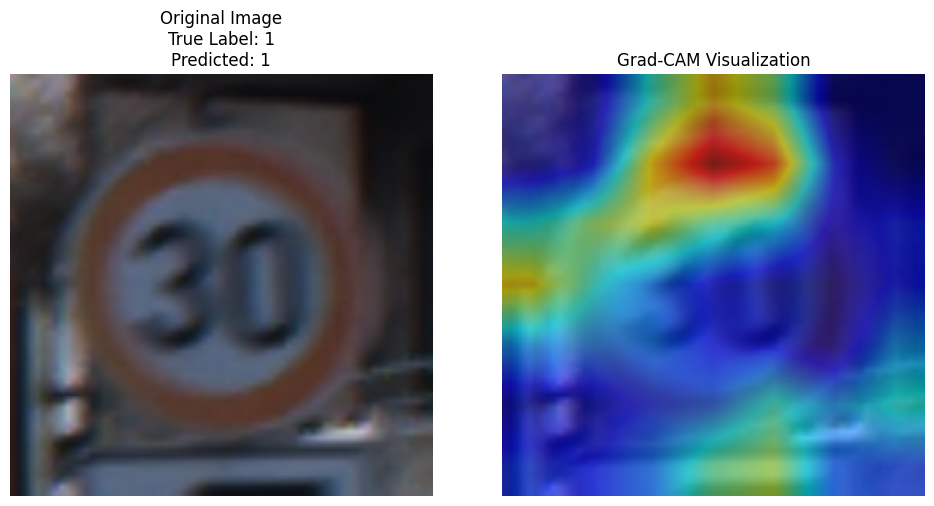

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Get a sample image and its true label from the test set
dataiter = iter(dataloaders['test'])

target_layer = model.layer4[-1].conv3

# Construct the GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Visualize Grad-CAM for the first 5 images
for i in range(5):
    try:
        images, labels = next(dataiter)
        sample_image = images[0].unsqueeze(0).to(device)
        true_label = labels[0].item()


        original_image_tensor = images[0]

        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        original_image_denorm = inv_normalize(original_image_tensor)
        original_image = transforms.ToPILImage()(original_image_denorm.cpu())

        original_image_np = np.array(original_image) / 255.0

        # Get the predicted class
        with torch.no_grad():
            output = model(sample_image)
            predicted_class = output.argmax(dim=1).item()

        # Specify the target category as a list of ClassifierOutputTarget
        targets = [ClassifierOutputTarget(predicted_class)]

        # Generate the heatmap
        grayscale_cam = cam(input_tensor=sample_image, targets=targets)

        # In this example, the image is in a batch of size 1, so we grab the first element.
        grayscale_cam = grayscale_cam[0, :]

        # Visualize the heatmap on the original image
        visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

        # Display the original image and the superimposed image
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f"Original Image\nTrue Label: {true_label}\nPredicted: {predicted_class}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title("Grad-CAM Visualization")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except StopIteration:
        print("Finished processing all available images in the first batch.")
        break

As seen above, the model correctly identifies the sign andwith the circle and truck at the center being the identifying features that allow for correct classification. The CNN focused on areas outside of the center of the sign-whcih I found strange-30km/hour for example.

Going to work employ a saliency map on the above model from a selected class.

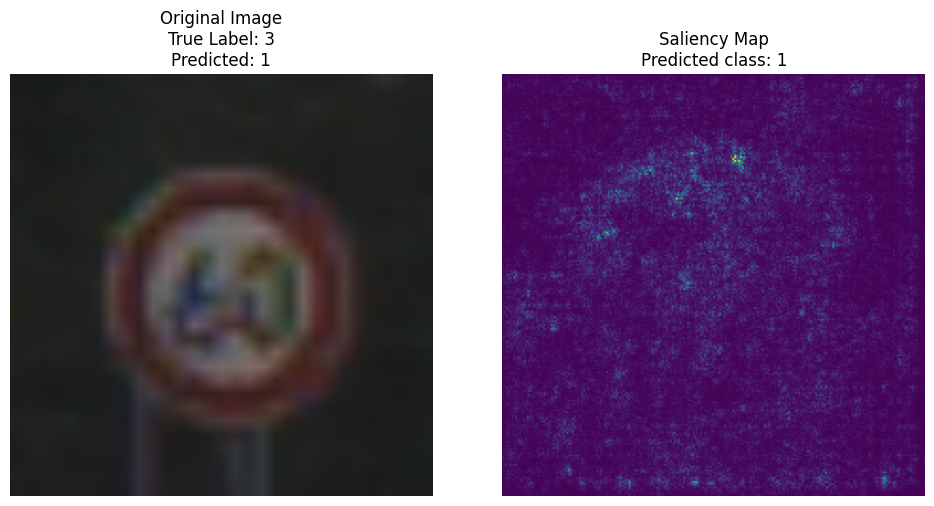

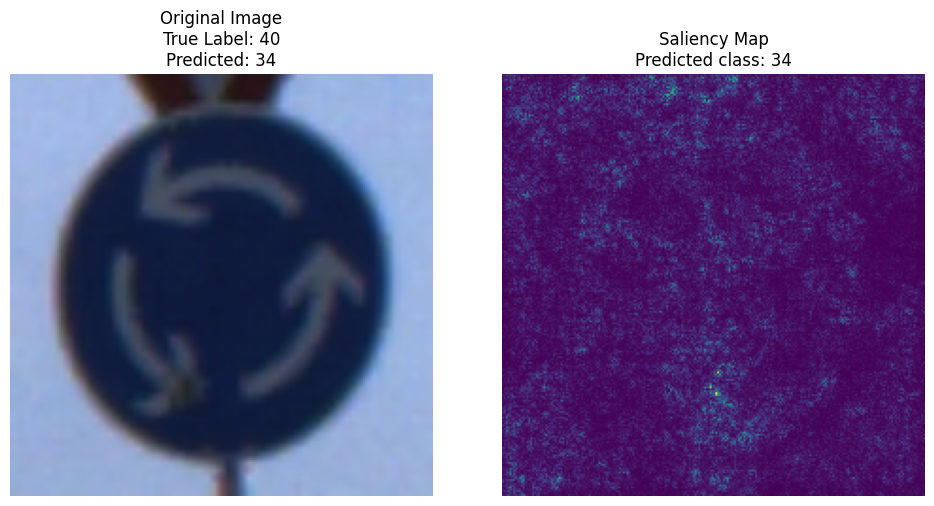

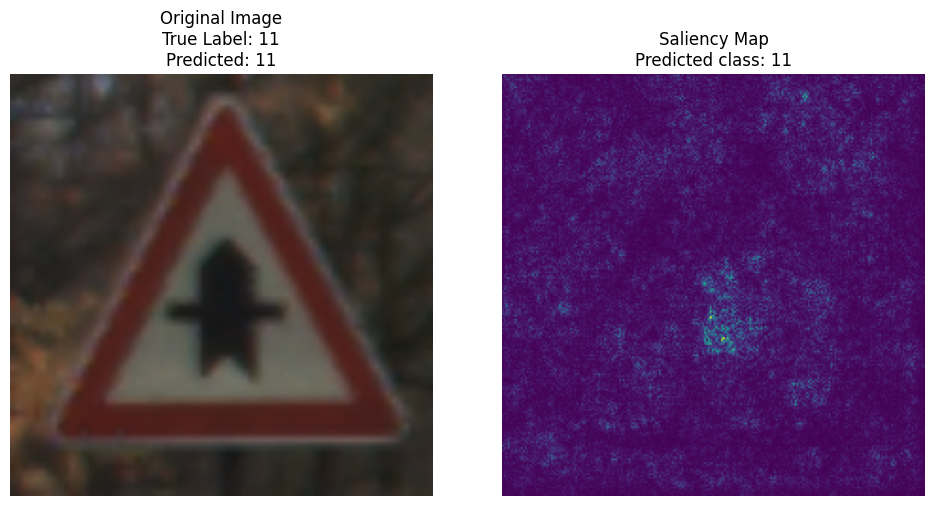

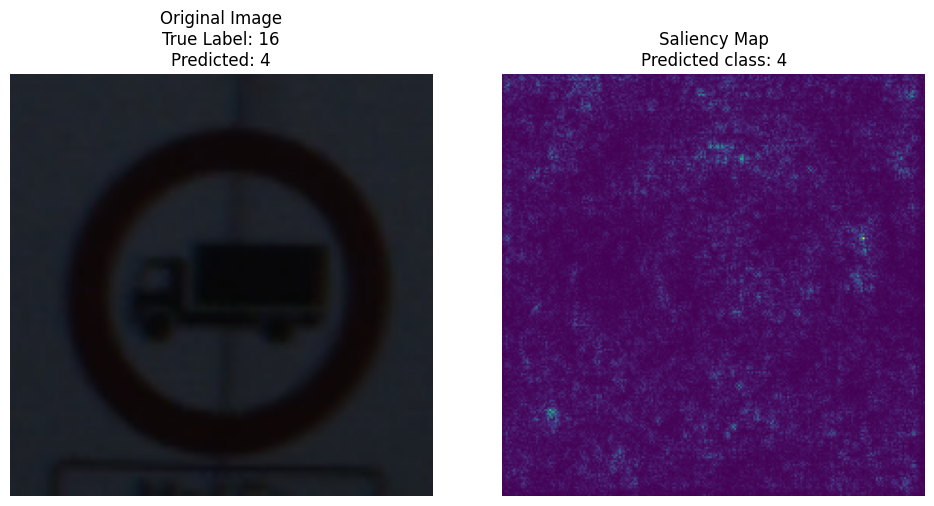

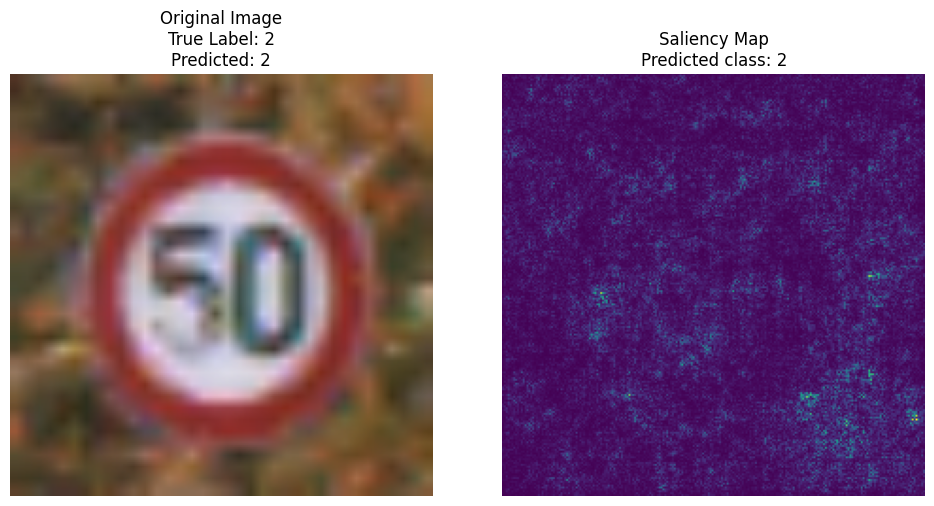

In [25]:
# Function to generate saliency map using PyTorch autograd
def generate_saliency_map(model, img_tensor):
    # Make sure input requires gradient
    img_tensor.requires_grad_()

    # Forward pass
    output = model(img_tensor.unsqueeze(0).to(img_tensor.device))

    # Get the index of the top predicted class
    top_pred_index = output.argmax(dim=1).item()

    # Zero existing gradients
    model.zero_grad()

    # Compute gradients of top output value w.r.t. input image
    output[0, top_pred_index].backward()

    # Get saliency map by taking max absolute gradient over the color channels
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=0)

    return saliency.cpu().numpy(), top_pred_index

# Get an iterator for the test dataloader
dataiter = iter(dataloaders['test'])

# Visualize Saliency Maps for the first 5 images (same as Grad-CAM)
for i in range(5):
    try:
        # Get a sample image and its true label from the test set
        images, labels = next(dataiter)
        sample_image_tensor = images[0]
        true_label = labels[0].item()

        # Get the original image for visualization (undo transformations for display)
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        original_image_denorm = inv_normalize(sample_image_tensor)
        original_image = transforms.ToPILImage()(original_image_denorm.cpu())


        # Preprocess image for the model
        img_tensor = data_transforms['test'](original_image).to(device)

        # Generate saliency map
        saliency_map, top_pred_index = generate_saliency_map(model, img_tensor)

        # Use the predicted class from the model's output
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device))
            predicted_class = output.argmax(dim=1).item()


        # Display original image and saliency map
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title(f"Original Image\nTrue Label: {true_label}\nPredicted: {predicted_class}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='viridis')
        plt.title(f"Saliency Map\nPredicted class: {predicted_class}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except StopIteration:
        print("Finished processing all available images in the first batch.")
        break

As seen above, the model incorrectly labels the sign as "No Entry" when it should be heavy truck prohibited sign. The saliency map has no clear indication of how the CNN was confused other than the fact both signs are circular.

In [22]:
# Get the unique class indices from the training dataset
unique_classes = set()
for _, target in image_datasets['train']:
    unique_classes.add(target)

print("Unique class indices in the training dataset:", sorted(list(unique_classes)))

Unique class indices in the training dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


Overall, GradCAM heatmaps were more focused on local regions that centered on the center icon. Saliency maps were more noisy and sprawling. The GradCAM revealed the model's focus on the center of the sign and shape. If used appropriately, they can compliment one another. For this particular scenario, it is imperative for model transparency to reveal any issues that require debugging, meeting regulatory standards and ensuring safety! With the roll out of autonomous driving, focus on transparency of CNN's with be even more paramount.